In [2]:
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from numba import njit
#from sklearn.cluster import KMeans
from cuml.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [3]:
import warnings
warnings.simplefilter(action='ignore')

In [4]:
def flatten_image(image):
    rows=image.shape[0]
    cols=image.shape[1]

    flat_im=image.reshape(rows*cols,3).copy()
    return flat_im

In [102]:
image=io.imread('IMG_20230528_144420_316.jpg')

In [6]:
def scores(new_im,image=image):
    print(f'PSNR = {peak_signal_noise_ratio(image,new_im)}')
    print(f'SSIM = {structural_similarity(image,new_im,win_size=3)}')

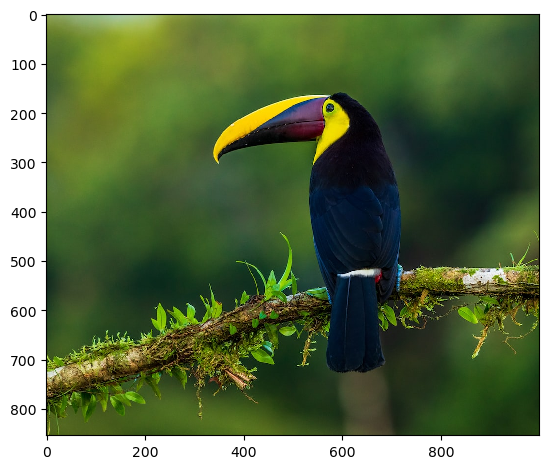

In [101]:
io.imshow(image)

## Regular KMeans Compression

In [44]:
def compress_reg(image,k):
    km=KMeans(n_clusters=k)
    flat_im=flatten_image(image)
    ## finding kmeans centroids and assigning clusters the centroid color
    km.fit(flat_im.astype('float32'))   

    compressed_im=km.cluster_centers_[km.labels_]

    compressed_im=compressed_im.astype('uint8')

    compressed_im=compressed_im.reshape(image.shape)

    
    return compressed_im

In [79]:
new_image=compress_reg(image,128)

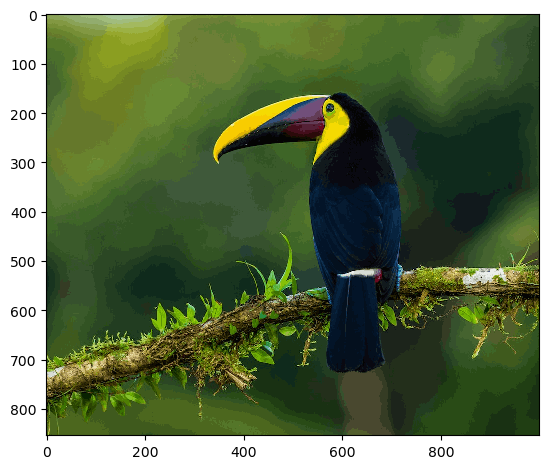

In [80]:
io.imshow(new_image)

In [81]:
scores(new_image)

PSNR = 34.65290440948513
SSIM = 0.9751648069903515


## Eigenvalue

In [8]:
@njit
def mean_eig_cov(A):
    return np.mean(la.eigvalsh(np.cov(A,rowvar=False)))

In [10]:
## divides up the image into chunks of 4x4 pixels and assigns a numerical index to each pixel
def slice_image(image,r=4,c=4):
    
    rows,cols = image.shape[:2]
    indices=np.arange(0,rows*cols).reshape(rows,cols)
    l=[];m=0;n=0;I=[]
    while n<rows:
        m=0
        while m<cols:
            l.append(image[n:n+r,m:m+c])
            I.append(indices[n:n+r,m:m+c])
            m+=c
        n+=r
    return l,I

In [85]:
## matches the image chunks with its respective indices
def assign_chunks_to_var(chunk_index,img_slices,Indices):
    chunks=[];indices=[]
    for i in chunk_index:
        chunks.append(img_slices[i])
        indices.append(Indices[i])
    return chunks,indices

In [108]:
## Function to compress image using k1 and k2 clusters after 
##     a discriminant(eg: mean eigenvalues in the case of compression using covariance matrix) has been found

def compress_kmeans(discriminator,img_slices,Indices,k1,k2,image):
    print('Compressing Image...')
    
     ## dividing the image into 'low variance aka low' and 'high varaince aka high' regions
        
    index=np.arange(len(discriminator))
    index_l=index[discriminator<np.median(discriminator)] 
    index_h=index[discriminator>=np.median(discriminator)]
    
    ##setting up kmeans and assigning indices to chunks
    
    kml=KMeans(n_clusters=k1)
    kmh=KMeans(n_clusters=k2)
    low_chunks,low_indices=assign_chunks_to_var(index_l,img_slices,Indices)
    high_chunks,high_indices=assign_chunks_to_var(index_h,img_slices,Indices)

    ## stacking the list of chunks and indices row-wise
    high_chunks=np.vstack(high_chunks)
    high_chunks=high_chunks.reshape(np.product(high_chunks.shape[:2]),3)
    low_chunks=np.vstack(low_chunks)
    low_chunks=low_chunks.reshape(np.product(low_chunks.shape[:2]),3)
    
    ##clustering and assigning centroid colors to the cluster
    
    kml.fit(low_chunks.astype('float32'))  ##cuml only works with either 'float64' or 'float32'
    kmh.fit(high_chunks.astype('float32'))
    comp_low_chunk=kml.cluster_centers_[kml.labels_].astype('uint8')
    comp_high_chunk=kmh.cluster_centers_[kmh.labels_].astype('uint8')
    
    ##stacking indices
    low_indices=np.vstack(low_indices).flatten()
    high_indices=np.vstack(high_indices).flatten()
    
    ##reconstructing the image after compression
    new_image=np.zeros(image.shape)
    new_image=flatten_image(new_image)
    new_image[low_indices]=comp_low_chunk
    new_image[high_indices]=comp_high_chunk
    new_image=new_image.reshape(image.shape).astype('uint8')
    print('Done')
    return new_image

In [96]:
def compress_eig(image,k1=64,k2=256):
    print('Preparing Image...')
    
    img_slices,Indices=slice_image(image)
    
    ## computing the average mean eigenvalues of covaraince matrices within each chunk
    avg_eig=[mean_eig_cov(flatten_image(block)) for block in img_slices]
           
    return(compress_kmeans(avg_eig,img_slices,Indices,k1,k2,image))

In [97]:
new_image=compress_eig(image,k1=128,k2=512)

Preparing Image...
Compressing Image...
Done


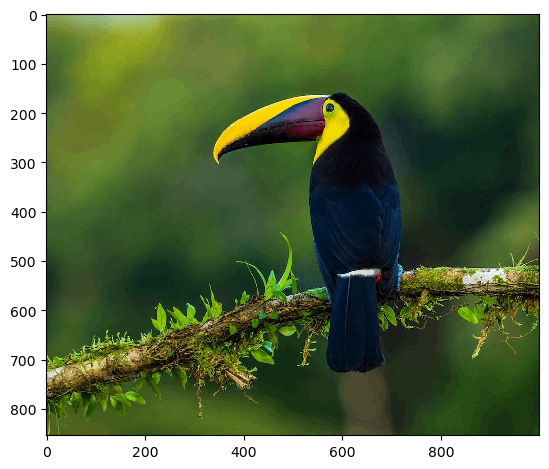

In [77]:
io.imshow(new_image)

In [78]:
scores(new_image)

PSNR = 38.63953809117219
SSIM = 0.9889156231724066


## Total Variance

In [104]:
def compress_var(image,k1=64,k2=256,TV=False):
    
    print('Preparing Image...')
    
    ## conversion to amplitude space
    gray_im=rgb2gray(image)

    img_slices,Indices=slice_image(image)
    gray_img_slices,gray_Indices=slice_image(gray_im)
    
    ## discriminant can be wither total variance using |grad(image)| or average variance withing each chunk
    if TV:
        variances=[]
        for img in gray_img_slices:
            gx,gy=np.gradient(img,axis=1),np.gradient(img,axis=0)
            variances.append(np.sum(np.sqrt(gx**2+gy**2)))
    else:        
        variances=[np.var(img) for img in gray_img_slices]
        
    return (compress_kmeans(variances,img_slices,Indices,k1,k2,image))

In [105]:
new_image=compress_var(image,k1=128,k2=512)

Preparing Image...
Compressing Image...
Done


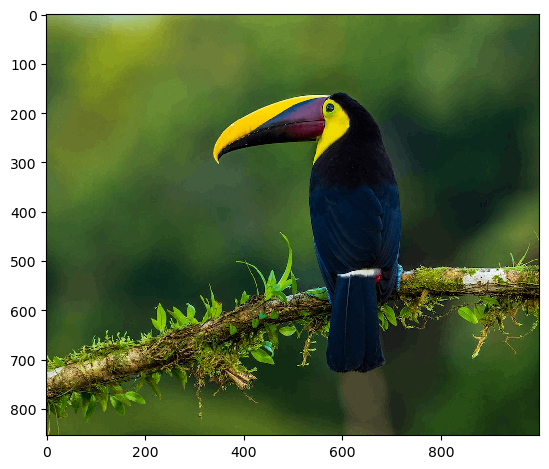

In [74]:
io.imshow(new_image) ##tv

In [75]:
scores(new_image)

PSNR = 38.53251592359064
SSIM = 0.9885354482920827
